<a href="https://colab.research.google.com/github/jems2019/ReinforcementBasedTradingPlatform/blob/master/notebooks/custom_anytrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libaries, gdrive


In [0]:
# Clone the entire repo.
!git clone -l -s https://github.com/jems2019/custom_anytrading.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 49 (delta 20), reused 36 (delta 15), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/cloned-repo
custom_anytrading  test.py


In [0]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install --upgrade gym==0.14
!pip uninstall -y stable-baselines
!pip install --upgrade stable-baselines==2.9

Requirement already up-to-date: gym==0.14 in /usr/local/lib/python3.6/dist-packages (0.14.0)
Uninstalling stable-baselines-2.9.0:
  Successfully uninstalled stable-baselines-2.9.0
  Using cached https://files.pythonhosted.org/packages/c0/05/f6651855083020c0363acf483450c23e38d96f5c18bec8bded113d528da5/stable_baselines-2.9.0-py3-none-any.whl


In [0]:
import json
import datetime as dt
import random 
import time
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pandas_datareader.data import DataReader

import gym
import custom_anytrading

import stable_baselines
print(stable_baselines.__version__)

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines.common.policies import CnnLnLstmPolicy

#for faster training
from stable_baselines.common import make_vec_env
#from stable_baselines.common.vec_env import DummyVecEnv, VecNormalize

from stable_baselines import PPO2

from sklearn.preprocessing import MinMaxScaler

2.9.0


In [0]:
import pandas_datareader
print(pandas_datareader.__version__)

0.8.1


In [0]:
print(pd.__version__)

1.0.3


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Load sentiment data

In [0]:
col_order = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'sentiment_score']

In [0]:
aapl = pd.read_csv('/gdrive/My Drive/Masters project/data/data_with_sent/sent_appl.csv')

#fix indexing, nans
aapl.drop(columns=['Unnamed: 0'], inplace=True)
aapl.set_index('Date', inplace=True)
aapl.fillna(0, inplace=True)
#aapl = aapl[col_order]
aapl.tail()

,Open,High,Low,Close,Adj Close,Volume,sentiment_score
Date,,,,,,,
2019-02-27,173.210007,175.000000,172.729996,174.869995,173.539795,27835400.0,-0.049580
2019-02-28,174.320007,174.910004,172.919998,173.149994,171.832886,28215400.0,-0.016533
2019-03-01,174.279999,175.149994,172.889999,174.970001,173.639038,25886200.0,0.072413
2019-03-04,175.690002,177.750000,173.970001,175.850006,174.512360,27436200.0,0.143187
2019-03-05,175.940002,176.000000,174.539993,175.529999,174.194778,19737400.0,0.064133


In [0]:
fb = pd.read_csv('/gdrive/My Drive/Masters project/data/data_with_sent/sent_fb.csv')

#fix indexing
fb.drop(columns=['Unnamed: 0'], inplace=True)
fb.set_index('Date', inplace=True)
fb.fillna(0, inplace=True)
fb

,Open,High,Low,Close,Adj Close,Volume,Sentiment Score
Date,,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400,0.011953
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700,0.184933
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600,-0.059887
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000,0.131733
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200,0.063067
...,...,...,...,...,...,...,...
2019-12-20,207.479996,207.710007,203.429993,206.300003,206.300003,27306900,0.067080
2019-12-23,206.699997,208.589996,205.679993,206.179993,206.179993,13348900,0.035373
2019-12-24,206.300003,206.789993,205.000000,205.119995,205.119995,6046300,0.053587


In [0]:
amzn = pd.read_csv('/gdrive/My Drive/Masters project/data/data_with_sent/sent_amaz.csv')

#fix indexing
amzn.drop(columns=['Unnamed: 0'], inplace=True)
amzn.set_index('Date', inplace=True)
amzn.fillna(0, inplace=True)
amzn

,Open,High,Low,Close,Adj Close,Volume,Sentiment Score
Date,,,,,,,
2000-01-03,81.500000,89.562500,79.046875,89.375000,89.375000,16117600,0.010847
2000-01-04,85.375000,91.500000,81.750000,81.937500,81.937500,17487400,-0.019460
2000-01-05,70.500000,75.125000,68.000000,69.750000,69.750000,38457400,0.070560
2000-01-06,71.312500,72.687500,64.000000,65.562500,65.562500,18752000,0.062627
2000-01-07,67.000000,70.500000,66.187500,69.562500,69.562500,10505400,0.014447
...,...,...,...,...,...,...,...
2019-11-22,1739.020020,1746.430054,1731.000000,1745.719971,1745.719971,2479100,0.078200
2019-11-25,1753.250000,1777.420044,1753.239990,1773.839966,1773.839966,3486200,0.161833
2019-11-26,1779.920044,1797.030029,1778.349976,1796.939941,1796.939941,3181200,0.126760


In [0]:
goog = pd.read_csv('/gdrive/My Drive/Masters project/data/data_with_sent/sent_goog.csv')

#fix indexing
goog.drop(columns=['Unnamed: 0'], inplace=True)
goog.set_index('Date', inplace=True)
goog.fillna(0, inplace=True)
goog

,Open,High,Low,Close,Adj Close,Volume,Sentiment Score
Date,,,,,,,
2006-09-11,188.423737,191.626740,188.179657,191.327850,191.327850,9092200,0.296000
2006-09-12,191.781158,195.631729,191.721375,195.218277,195.218277,10925100,0.000000
2006-09-13,196.837204,202.620529,196.812302,202.525879,202.525879,19609500,0.000000
2006-09-14,201.395126,202.381424,200.214554,201.235718,201.235718,10772300,0.000000
2006-09-15,202.979187,204.259384,202.610565,204.174698,204.174698,15735000,0.000000
...,...,...,...,...,...,...,...
2019-12-20,1363.349976,1363.640015,1349.000000,1349.589966,1349.589966,3315000,-0.021073
2019-12-23,1355.869995,1359.800049,1346.510010,1348.839966,1348.839966,883100,0.000000
2019-12-24,1348.500000,1350.260010,1342.780029,1343.560059,1343.560059,347500,0.015853


## put sentiment data into dict for cycle training

In [0]:
stock_lib = {
    'aapl': aapl,
    'fb':fb,
    'amzn':amzn,
    'goog':goog,
}

In [0]:
symbols = list(stock_lib.keys())
symbols

['aapl', 'fb', 'amzn', 'goog']

In [0]:
stock_lib['aapl']

,Open,High,Low,Close,Adj Close,Volume,sentiment_score
Date,,,,,,,
1999-10-01,2.218750,2.229911,2.125000,2.204241,1.923671,153697600.0,-0.012380
1999-10-04,2.227679,2.316964,2.227679,2.305804,2.012305,114839200.0,0.000000
1999-10-05,2.343750,2.433036,2.312500,2.426339,2.117498,203551600.0,0.000000
1999-10-06,2.477679,2.486607,2.392857,2.399554,2.094123,201068000.0,0.000000
1999-10-07,2.444196,2.450893,2.316964,2.370536,2.068798,151471600.0,0.000000
...,...,...,...,...,...,...,...
2019-02-27,173.210007,175.000000,172.729996,174.869995,173.539795,27835400.0,-0.049580
2019-02-28,174.320007,174.910004,172.919998,173.149994,171.832886,28215400.0,-0.016533
2019-03-01,174.279999,175.149994,172.889999,174.970001,173.639038,25886200.0,0.072413


## Load regular data


In [0]:
symbol = 'AAPL'

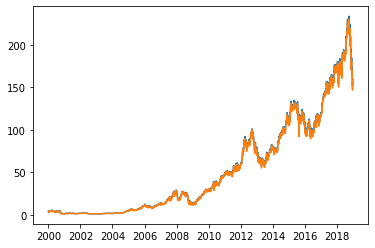

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,151.550003,146.589996,148.149994,146.830002,37169200.0,144.314041
2018-12-26,157.229996,146.720001,148.300003,157.169998,58582500.0,154.476852
2018-12-27,156.770004,150.070007,155.839996,156.149994,53117100.0,153.474335
2018-12-28,158.520004,154.550003,157.500000,156.229996,42291400.0,153.552979
2018-12-31,159.360001,156.479996,158.529999,157.740005,35003500.0,155.037109


In [0]:
data = DataReader(symbol, 'yahoo', start='2000-01-01', end='2018-12-31')
plt.plot(data['High'])
plt.plot(data['Low'])
plt.show()
data.tail()

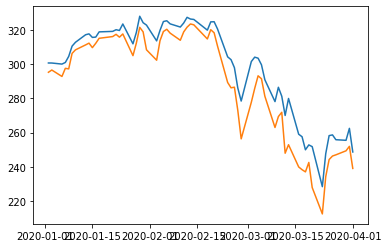

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-26,258.679993,246.360001,246.520004,258.440002,63021800.0,258.440002
2020-03-27,255.869995,247.050003,252.750000,247.740005,51054200.0,247.740005
2020-03-30,255.520004,249.399994,250.740005,254.809998,41994100.0,254.809998
2020-03-31,262.489990,252.000000,255.600006,254.289993,49147500.0,254.289993
2020-04-01,248.720001,239.130005,246.500000,240.910004,39970688.0,240.910004


In [0]:
test_data = DataReader(symbol, 
                       'yahoo', 
                       #start='2019-06-01', 
                       start='2020-01-01',
                       )
plt.plot(test_data['High'])
plt.plot(test_data['Low'])
plt.show()
test_data.tail()

## Load a group of stocks for cycle training

In [0]:
symbols = ['AAPL', 'GOOG', 'FB', 'AMZN', 'TWTR', 'TSLA', 'KO', 'MCD']
start_date = '2000-01-01'
end_date = datetime.now()

In [0]:
stock_lib = dict()
for s in symbols:
    print('Loading ' + s + '...')
    stock_lib[s] = DataReader(s, 'yahoo', start=start_date, end=end_date)

Loading AAPL...
Loading GOOG...
Loading FB...
Loading AMZN...
Loading TWTR...
Loading TSLA...
Loading KO...
Loading MCD...


In [0]:
stock_lib['AAPL']

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.470226
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.177650
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.224152
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.945139
2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,3.084645
...,...,...,...,...,...,...
2020-03-27,255.869995,247.050003,252.750000,247.740005,51054200.0,247.740005
2020-03-30,255.520004,249.399994,250.740005,254.809998,41994100.0,254.809998
2020-03-31,262.489990,252.000000,255.600006,254.289993,49250500.0,254.289993


## build training environments

In [0]:
# test_data = data.tail(200)
# train_data = data.head(-500)

In [0]:
env = gym.make(
    'custom_stocks-v0',
    stock_df = data,
    pred_df = data,
    window_size = 14,
    initial_balance = 5000,
    min_percent_loss = .5,
    with_pred = False
    )

In [0]:
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)

env.reset()

obs, rewards, done, info = env.step([0,0,1,0])
print(obs)

env information:
> shape: (14, 6)
> df.shape: (4779, 6)
                High       Low      Open     Close    Volume  Adj Close
Date                                                                   
2002-04-11  0.004240  0.004102  0.004188  0.004136  0.049837   0.003129
2002-04-12  0.004231  0.004047  0.004182  0.004197  0.038051   0.003182
2002-04-15  0.004225  0.004117  0.004197  0.004179  0.035223   0.003166
2002-04-16  0.004483  0.004216  0.004225  0.004406  0.077921   0.003363
2002-04-17  0.004538  0.004296  0.004464  0.004520  0.048347   0.003462
2002-04-18  0.004338  0.004142  0.004332  0.004305  0.049086   0.003275
2002-04-19  0.004329  0.004157  0.004329  0.004173  0.045523   0.003161
2002-04-22  0.004157  0.003942  0.004130  0.004035  0.031167   0.003041
2002-04-23  0.004111  0.003899  0.004038  0.003949  0.026297   0.002966
2002-04-24  0.004025  0.003774  0.003964  0.003801  0.013696   0.002838
2002-04-25  0.003976  0.003734  0.003737  0.003909  0.020978   0.002931
2002-04-

/content/cloned-repo/custom_anytrading/envs/custom_stock_env.py:180: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)


In [0]:
num_envs = 8

vec_env = make_vec_env(
    custom_anytrading.envs.CustomStockEnv, 
    env_kwargs = {'stock_df' : data,
                'pred_df' : data,
                'window_size' : 14,
                'initial_balance' : 5000,
                'min_percent_loss' : .5,
                'with_pred' : False
                },
    n_envs=num_envs)

## cycle stock training envs


In [0]:
#needed to load the custom_anytrading.envs?
temp = gym.make(
    'custom_stocks-v0',
    stock_df = stock_lib[symbols[0]],
    pred_df = stock_lib[symbols[0]],
    window_size = 14,
    initial_balance = 5000,
    min_percent_loss = .5,
    with_pred = True
    )

In [0]:
cycle_stock_envs = dict()
num_envs = 8

for s in stock_lib.keys():
    print('Building env for ' + s)
    cycle_stock_envs[s] = make_vec_env(
            custom_anytrading.envs.CustomStockEnv, 
            env_kwargs = {'stock_df' : stock_lib[s],
            'pred_df' : stock_lib[s],
            'window_size' : 14,
            'initial_balance' : 5000,
            'min_percent_loss' : .5,
            'with_pred' : True
            },
        n_envs=num_envs)

Building env for aapl
Building env for fb
Building env for amzn
Building env for goog


## Build and train model

In [0]:
model = PPO2(MlpPolicy, cycle_stock_envs['AAPL'])

In [0]:
%%time
model.learn(
    total_timesteps=2000000,
    )

model.save('/gdrive/My Drive/Masters project/data/models/aapl_trained_model_pred.zip')

/content/cloned-repo/custom_anytrading/envs/custom_stock_env.py:180: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)


CPU times: user 37min, sys: 45.6 s, total: 37min 45s
Wall time: 34min 44s


### cycle stock envs in trading


In [0]:
model = PPO2(MlpPolicy, cycle_stock_envs[symbols[0]])

In [0]:
num_cycles = 2
start_time = time.time()

for x in range(num_cycles):
    print('On cycle ' + str(x+1))
    for s in cycle_stock_envs.keys():
        print('Training on ' + s)
        model.set_env(cycle_stock_envs[s])
        model.learn(total_timesteps = 250000)
        print('elapsed time: ' + str((time.time()-start_time)/60) + ' min')
    print('Saving model')
    model.save('/gdrive/My Drive/Masters project/data/models/cycle_trained_model_sent_pred_2_cycle.zip')



On cycle 1
Training on aapl


/content/cloned-repo/custom_anytrading/envs/custom_stock_env.py:180: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)


elapsed time: 3.630121115843455 min
Training on fb
elapsed time: 8.514829345544179 min
Training on amzn
elapsed time: 13.378830103079478 min
Training on goog
elapsed time: 18.223041252295175 min
Saving model
On cycle 2
Training on aapl
elapsed time: 21.77551728884379 min
Training on fb
elapsed time: 26.626224120457966 min
Training on amzn
elapsed time: 31.459122069676717 min
Training on goog
elapsed time: 36.28467314640681 min
Saving model


## load a trained model

In [0]:
#sent_model = PPO2.load('/gdrive/My Drive/Masters project/data/models/aapl_trained_model_sent_real_pred.zip')

aapl_base_model = PPO2.load('/gdrive/My Drive/Masters project/data/models/aapl_trained_model_base.zip')

cycle_base_model = PPO2.load('/gdrive/My Drive/Masters project/data/models/cycle_trained_model_base.zip')

aapl_sent_model = PPO2.load('/gdrive/My Drive/Masters project/data/models/aapl_trained_model_sent_real_pred.zip')

cycle_sent_model = PPO2.load('/gdrive/My Drive/Masters project/data/models/cycle_trained_model_sent_pred.zip')

## build a testing env

In [0]:
# symbol = 'FB'
# data = DataReader(symbol, 'yahoo', start='2018-01-01', end='2020-01-01')
# test_data = DataReader(symbol, 'yahoo', start='2019-06-01', end='2019-12-31')

# Load sentiment data
test_data = pd.read_csv('/gdrive/My Drive/Masters project/data/data_with_sent/aapl_sent_test.csv')
test_data.set_index('Date', inplace=True)
data = aapl
test_data

,Open,High,Low,Close,Adj Close,Volume,Sentiment Score
Date,,,,,,,
2020-01-02,296.239990,300.600006,295.190002,300.350006,299.638885,33870100.0,0.123113
2020-01-03,297.149994,300.579987,296.500000,297.429993,296.725769,36580700.0,0.143487
2020-01-06,293.790009,299.959991,292.750000,299.799988,299.090149,29596800.0,0.110053
2020-01-07,299.839996,300.899994,297.480011,298.390015,297.683533,27218000.0,0.169673
2020-01-08,297.160004,304.440002,297.160004,303.190002,302.472137,33019800.0,0.116347
...,...,...,...,...,...,...,...
2020-03-25,250.750000,258.250000,244.300003,245.520004,245.520004,75900500.0,-0.104667
2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800.0,-0.021880
2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200.0,0.115967


In [0]:
test_env = gym.make(
    'custom_stocks-v0',
    stock_df = test_data,
    pred_df = test_data,
    window_size = 14,
    initial_balance = 5000,
    min_percent_loss = 1,
    with_pred = True,
    test_env = True,
    train_df = data
    )

This is a testing environment, scaling based on training data.


env information:
> shape: (14, 7)
> df.shape: (62, 7)
        Open      High       Low  ...  Adj Close    Volume  Sentiment Score
0   1.365825  1.371886  1.360366  ...   1.358810  0.008465         0.036633
1   1.362988  1.370037  1.353231  ...   1.365370  0.008823         0.094407
2   1.373003  1.386242  1.361269  ...   1.361425  0.014521         0.293060
3   1.329204  1.336554  1.306939  ...   1.321289  0.016607         0.083800
4   1.340122  1.365051  1.338359  ...   1.358767  0.016647         0.041007
5   1.391056  1.405670  1.377860  ...   1.387282  0.023961        -0.009940
6   1.374250  1.389509  1.366556  ...   1.385267  0.011840         0.061727
7   1.375926  1.383448  1.321596  ...   1.323690  0.021707         0.086873
8   1.304446  1.343947  1.295506  ...   1.320045  0.018239         0.028740
9   1.351770  1.370381  1.344549  ...   1.363741  0.013177         0.041293
10  1.387058  1.392388  1.367416  ...   1.374890  0.010767        -0.013047
11  1.382975  1.394366  1.373046  

/content/cloned-repo/custom_anytrading/envs/custom_stock_env.py:180: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)


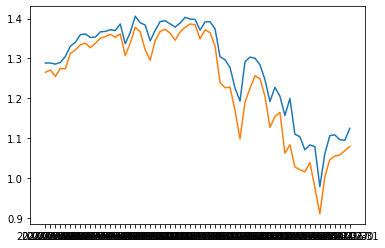

In [0]:
print("env information:")
print("> shape:", test_env.shape)
print("> df.shape:", test_env.df.shape)

test_env.reset()

obs, rewards, done, info = test_env.step([0,0,1,0])
print(obs)

plt.plot(test_env.scale_df['High'])
plt.plot(test_env.scale_df['Low'])
plt.show()

# Run a testing simulation

In [0]:
def test_model(model, env, sims):
    profits = []
    stocks_held = []
    net_worth = []

    for i in range(sims):
        obs = env.reset()
        stocks_held = []
        net_worth = []
        while True:
            action, _states = model.predict(obs)
            obs, rewards, done, info = env.step(action)
            stocks_held.append(info['shares'])
            net_worth.append(info['net_worth'])
            if done:
                if(i%10 == 0):
                    print('finished sim %d/%d'%(i,sims))
                profits.append(info['profit'])
                break


    pos_count = len(list(filter(lambda x: (x >= 0), profits))) 
    print('made profit - ' + str(pos_count/len(profits)))
    print('mean profit - ' + str(np.mean(profits)))

    plt.hist(profits)
    plt.show()

    #env.render()

    print('stocks held per time')
    plt.plot(stocks_held)
    plt.show()

    print('net worth per time')
    plt.plot(net_worth)
    plt.show()

In [0]:
def rand_test_env(env, sims):
    profits = []
    stocks_held = []
    net_worth = []

    for i in range(sims):
        obs = env.reset()
        stocks_held = []
        net_worth = []
        while True:
            #random action
            action = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]

            obs, rewards, done, info = env.step(action)
            stocks_held.append(info['shares'])
            net_worth.append(info['net_worth'])
            if done:
                if(i%10 == 0):
                    print('finished sim %d/%d'%(i,sims))
                profits.append(info['profit'])
                break


    pos_count = len(list(filter(lambda x: (x >= 0), profits))) 
    print('made profit - ' + str(pos_count/len(profits)))
    print('mean profit - ' + str(np.mean(profits)))


    plt.hist(profits)
    plt.show()

    #env.render()

    print('stocks held per time')
    plt.plot(stocks_held)
    plt.show()

    print('net worth per time')
    plt.plot(net_worth)
    plt.show()

finished sim 0/100
finished sim 10/100
finished sim 20/100
finished sim 30/100
finished sim 40/100
finished sim 50/100
finished sim 60/100


/content/cloned-repo/custom_anytrading/envs/custom_stock_env.py:180: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)


finished sim 70/100
finished sim 80/100
finished sim 90/100
made profit - 0.13
mean profit - -297.003174742596


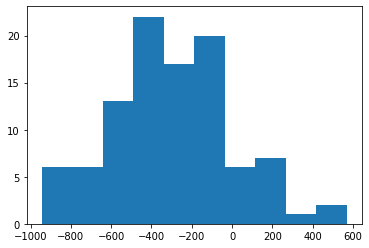

stocks held per time


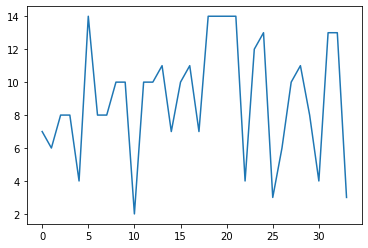

net worth per time


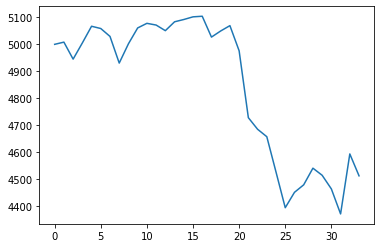

In [0]:
rand_test_env(test_env, 100)

/content/cloned-repo/custom_anytrading/envs/custom_stock_env.py:180: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)


finished sim 0/100
finished sim 10/100
finished sim 20/100
finished sim 30/100
finished sim 40/100
finished sim 50/100
finished sim 60/100
finished sim 70/100
finished sim 80/100
finished sim 90/100
made profit - 0.42
mean profit - -78.49201204541197


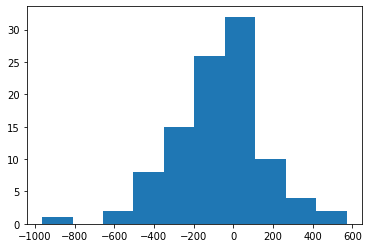

stocks held per time


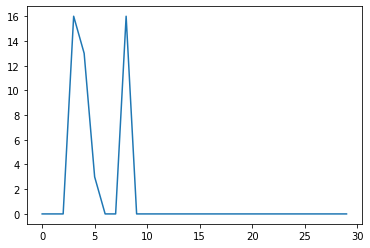

net worth per time


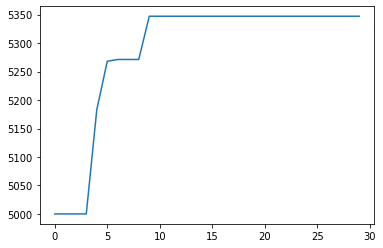

In [0]:
test_model(model, test_env, 100)

/content/cloned-repo/custom_anytrading/envs/custom_stock_env.py:180: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)


finished sim 0/100
finished sim 10/100
finished sim 20/100
finished sim 30/100
finished sim 40/100
finished sim 50/100
finished sim 60/100
finished sim 70/100
finished sim 80/100
finished sim 90/100
made profit - 0.69
mean profit - 129.9693263721134


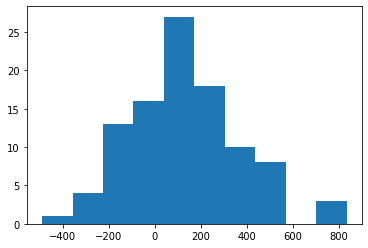

stocks held per time


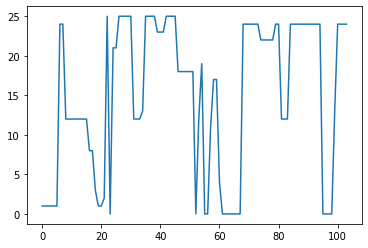

net worth per time


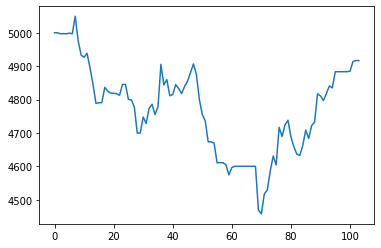

In [0]:
test_model(aapl_base_model, test_env, 100)

## test the sentiment model

In [0]:
data = aapl

test_env = gym.make(
    'custom_stocks-v0',
    stock_df = data.tail(200),
    pred_df = data.tail(200),
    window_size = 14,
    initial_balance = 5000,
    min_percent_loss = 1,
    with_pred = True,
    test_env = True,
    train_df = data.head(-500)
    )

This is a testing environment, scaling based on training data.


env information:
> shape: (14, 7)
> df.shape: (200, 7)
        Open      High       Low  ...  Adj Close    Volume  sentiment_score
0   1.366479  1.375227  1.364758  ...   1.347048  0.003834         0.022900
1   1.373865  1.377163  1.359668  ...   1.335931  0.006396         0.067707
2   1.367627  1.367770  1.358090  ...   1.336635  0.006380         0.032527
3   1.356728  1.357660  1.344036  ...   1.322844  0.028113         0.017347
4   1.341311  1.350920  1.336435  ...   1.322140  0.004687         0.074553
5   1.321664  1.330197  1.309546  ...   1.300680  0.012865        -0.149687
6   1.330341  1.336435  1.325895  ...   1.306379  0.005848        -0.127927
7   1.336794  1.344681  1.320230  ...   1.299062  0.008603         0.014393
8   1.328691  1.328906  1.318509  ...   1.295262  0.009409         0.062287
9   1.309188  1.320087  1.290043  ...   1.275913  0.011827        -0.127067
10  1.306248  1.331631  1.303021  ...   1.291815  0.007984         0.008713
11  1.322310  1.337009  1.313705 

/content/cloned-repo/custom_anytrading/envs/custom_stock_env.py:180: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)


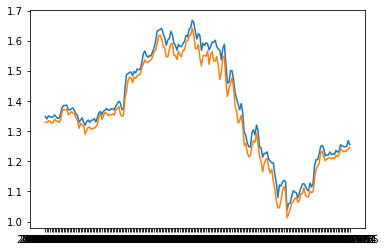

In [0]:
print("env information:")
print("> shape:", test_env.shape)
print("> df.shape:", test_env.df.shape)

test_env.reset()

obs, rewards, done, info = test_env.step([0,0,1,0])
print(obs)

plt.plot(test_env.scale_df['High'])
plt.plot(test_env.scale_df['Low'])
plt.show()

/content/cloned-repo/custom_anytrading/envs/custom_stock_env.py:180: RuntimeWarning: invalid value encountered in double_scalars
  self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)


finished sim 0/100
finished sim 10/100
finished sim 20/100
finished sim 30/100
finished sim 40/100
finished sim 50/100
finished sim 60/100
finished sim 70/100
finished sim 80/100
finished sim 90/100
[2307.456070263337, 3756.9039918443123, 2191.660030144515, 2194.5763109500267, 3750.9760342986483, 1928.1895452908748, 2557.104162094206, 3102.6185883117587, 1071.688630884325, 2389.8758037253792, 1663.6522880063621, 2050.9681623276365, 2379.379501374756, 2888.5150092618887, 3500.1267084943865, 2930.2367990928515, 3838.020015514776, 2949.143715690425, 2487.302515303769, 2437.14322895247, 1764.462553099549, 2524.995309318736, 3922.719880625842, 1796.4268765659926, 2378.4500887507475, 1843.8055725203685, 2969.9553914041317, 2036.4900480414408, 1829.2416205346171, 2928.715086561967, 2412.4481708567573, 3792.772357822734, 1945.901530011889, 2305.988072432444, 2608.4384853524407, 3750.632788966719, 3029.283826388668, 1868.4264796756433, 2869.7908750428696, 2874.6780783311087, 4222.652978117143, 

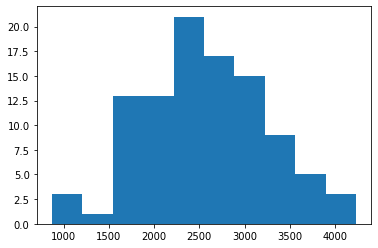

mode: with predictions
Step: 14
initial_balance: 5000
min_balance: 0
Balance: 53.58382846058066
Shares held: 39 (Total sold: 514)
Avg cost for held shares: 143.15697861236157 (Total sales value: 103358.3327504478)
Net worth: 6693.045326273852 (Max net worth: 6849.259183294014)
Profit: 1693.045326273852


In [0]:
profits = []
sims = 100

for i in range(sims):
    obs = test_env.reset()
    while True:
        action, _states = sent_model.predict(obs)
        obs, rewards, done, info = test_env.step(action)
        if done:
            if(i%10 == 0):
                print('finished sim %d/%d'%(i,sims))
            profits.append(info['profit'])
            break

print(profits)

pos_count = len(list(filter(lambda x: (x >= 0), profits))) 
print('made profit - ' + str(pos_count/len(profits)))

plt.hist(profits)
plt.show()

test_env.render()

# Load LSTM model for predictions

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from pandas_datareader.data import DataReader
from tensorflow.python.keras.models import load_model
import datetime
from datetime import date, datetime, timedelta

from google.colab import drive
drive.mount('/content/drive')
lstm_model_path = '/content/drive/My Drive/Masters project/LSTM_model_4.h5'


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Method parameters: stock ticker, start date, number of days to predict
# Return: dataframe with predictions

class LSTMStockPrediction():
    # ticker - stock ticker
    # d - day (YYYY-MM-DD) to start the prediction
    # n - number of days to predict starting from date d
    def __init__(self, model):

        self.model = model
        self.history_len = 60

    def predict(self, ticker, d, n):
        # getting previous 90 days of stock data
        startDate = datetime.strptime(d, '%Y-%m-%d') - timedelta(days=self.history_len+self.history_len)
        # Preparing data for prediction
        data = DataReader(ticker, 'yahoo', start=startDate, end=d)

        # Using last 60 stock data for LSTM model
        inputClosing = data.tail(self.history_len)

        sc = MinMaxScaler(feature_range=(0,1)) # scaling data
        inputClosing_scaled = sc.fit_transform(inputClosing)

        # output list
        out = []

        #for n days, do predictions
        #appends the results for 
        for i in range(n):
            #reshape input for model
            model_input = np.reshape(inputClosing_scaled[i:i+self.history_len,:].T, (data.shape[1],self.history_len,1))
            #do predictions
            pred = self.model.predict(model_input)
            #reflip and transform
            predicted_price = sc.inverse_transform(pred.T)
            #put the results to the end of the history array and fix dims
            inputClosing_scaled = np.append(inputClosing_scaled, [pred]).reshape(inputClosing_scaled.shape[0]+1 ,data.shape[1])
            inputClosing_scaled = np.expand_dims(inputClosing_scaled, axis=1)
            #put results to out array
            out.append(predicted_price)

        #convert array to dataframe, use the colums from data
        out = pd.DataFrame(np.concatenate(out), columns=data.columns)
        return out


lstm_model_path = '/content/drive/My Drive/Masters project/LSTM_model_4.h5'
model = load_model(lstm_model_path)
lstm = LSTMStockPrediction(model)
lstm.predict('FB', '2020-01-01', 7)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


,High,Low,Open,Close,Volume,Adj Close
0,210.855881,208.357361,209.891296,209.743820,12297311.0,209.743820
1,210.876205,208.452606,210.182205,209.660675,10456580.0,209.660675
2,210.806915,208.386963,210.259979,209.540024,9309792.0,209.540024
3,210.891098,208.454544,210.396652,209.633835,8829104.0,209.633835
4,211.222366,208.781708,210.733841,210.019089,8792432.0,210.019089
5,211.764847,209.343536,211.278488,210.633835,8923505.0,210.633835
6,212.417084,210.033524,211.953506,211.354843,9007411.0,211.354843


# load PPO2 model for real time predictions

In [0]:
class RLModel():
    def __init__(self, rl_model, pred_model, sent_crawler):

        self.rl_model = rl_model
        #length of observation
        self.obs_len = 14
        #date for scaling historical data
        self.scaling_start_date = '2016-01-01'

        self.pred_model = pred_model
        self.sent_crawler = sent_crawler

    def _scale_df(self, scaling_df, target_df):
        price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']
        high = scaling_df['High'].max()
        low = scaling_df['Adj Close'].min()
        diff = high - low

        #scale stock info by same scales
        target_df[price_columns] = target_df[price_columns].applymap(lambda x: ((x-low)/diff))

        #scale volume by itself
        scaler = MinMaxScaler()
        scaler.fit(scaling_df['Volume'].to_numpy().reshape(-1, 1))
        target_df['Volume'] = scaler.transform(target_df['Volume'].to_numpy().reshape(-1, 1))

        return target_df

    def get_action(self, ticker, day):
        #get data
        history_start_date = datetime.strptime(day, '%Y-%m-%d') - timedelta(days=self.obs_len)

        scaling_df =  DataReader(ticker, 'yahoo', start=self.scaling_start_date)
        history_df =  DataReader(ticker, 'yahoo', start=history_start_date, end=day)
        history_df = history_df.tail(self.obs_len//2)

        #get sentiment for history_df
        sent_df = sent_crawler.get_sentiment(ticker, history_df.index)

        # merge sent and stock together
        history_df = pd.merge(history_df, sent_df, on='Date')
        history_df.fillna(inplace=True, value=0)

        #make lstm prediction data
        pred_df = self.pred_model.predict(ticker, day, self.obs_len//2)

        #combine historical data and prediction data
        obs_df = history_df.append(pred_df, ignore_index=True)
        # set sentiment for future pred at 0
        obs_df.fillna(inplace=True, value=0)

        #scale data
        obs_df = self._scale_df(scaling_df, obs_df)
        print(obs_df)

        #rearrange input to match the training data
        col_order = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiment Score']
        obs_df = obs_df[col_order]

        #make rl prediction
        action, _states = self.rl_model.predict(obs_df)

        return action 


In [0]:

aapl_sent_model = PPO2.load('/content/drive/My Drive/Masters project/data/models/aapl_trained_model_sent_real_pred.zip')
lstm_model = LSTMStockPrediction(load_model('/content/drive/My Drive/Masters project/LSTM_model_4.h5'))
sent_crawler = SentimentCrawler()

test_model = RLModel(aapl_sent_model, lstm_model, sent_crawler)
today = datetime.today().strftime('%Y-%m-%d')
test_model.get_action('AAPL', '2020-01-01')





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.







[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2020-04-02 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F2%2F2020&rs=true
2020-04-03 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F3%2F2020&rs=true
2020-04-06 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F6%2F2020&rs=true
2020-04-07 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F7%2F2020&rs=true
2020-04-08 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F8%2F2020&rs=true
2020-04-09 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=t

array([1., 1., 1., 1.], dtype=float32)

In [0]:
test_model.get_action('AAPL', '2018-01-01')

2017-12-20 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=12%2F20%2F2017&rs=true
2017-12-21 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=12%2F21%2F2017&rs=true
2017-12-22 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=12%2F22%2F2017&rs=true
2017-12-26 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=12%2F26%2F2017&rs=true
2017-12-27 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=12%2F27%2F2017&rs=true
2017-12-28 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=12%2F28%2F2017&rs=true
2017-12-29 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=12%2F29%2F2017&rs=true
        High       Low      Open  ...    Volume  Adj Close  Sentiment Score
0   0.371830  

array([0.7654313, 1.       , 1.       , 1.       ], dtype=float32)

# test Sentiment 

In [0]:
!pip install alpha-vantage

  Created wheel for alpha-vantage: filename=alpha_vantage-2.1.3-cp36-none-any.whl size=14870 sha256=7fa39f4bb68db9b1476656b07c5b87d993872cee851a97fd0b5af695a674917d
  Stored in directory: /root/.cache/pip/wheels/d4/75/c2/483b0a988fd965b1128c1396a0ffadfb8903bd2bb569220048
Successfully built alpha-vantage


In [0]:
# import future
from bs4 import BeautifulSoup
from datetime import date, datetime, timedelta

import requests
import nltk
import warnings
import json
import pdb
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from pandas_datareader.data import DataReader

# from flask import Flask, request, jsonify
# from flask_restful import Api, Resource, reqparse

import random
import pandas as pd

# from alpha_vantage.timeseries import TimeSeries
# from alpha_vantage.techindicators import TechIndicators
# from alpha_vantage.sectorperformance import SectorPerformances

warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')
sent_analysis = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
nltk.__version__

'3.2.5'

In [0]:
today = datetime.today().strftime('%Y-%m-%d')

print(today)
history_start_date = datetime.strptime(str(today), '%Y-%m-%d') - timedelta(days=14)

history_df =  DataReader('AAPL', 'yahoo', start=history_start_date, end=today)
history_df = history_df.tail(7)
print(history_df.index)

sent_crawler = SentimentCrawler()

sent_data = sent_crawler.get_sentiment('AAPL', history_df.index)



2020-04-13
DatetimeIndex(['2020-04-02', '2020-04-03', '2020-04-06', '2020-04-07',
               '2020-04-08', '2020-04-09', '2020-04-13'],
              dtype='datetime64[ns]', name='Date', freq=None)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2020-04-02 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F2%2F2020&rs=true
2020-04-03 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F3%2F2020&rs=true
2020-04-06 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F6%2F2020&rs=true
2020-04-07 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F7%2F2020&rs=true
2020-04-08 00:00:00
https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv=4%2F8%2F2020&rs=true
2020-04-09 00:00:00
https://www

MergeError: ignored

In [0]:
temp = pd.merge(history_df, sent_data, on='Date')

x = temp.append(history_df, ignore_index=True)

x

,High,Low,Open,Close,Volume,Adj Close,Sentiment Score
0,245.149994,236.899994,240.339996,244.929993,41483500,244.929993,-0.019727
1,245.699997,238.970001,242.800003,241.410004,32470000,241.410004,-0.056653
2,263.109985,249.380005,250.899994,262.470001,50455100,262.470001,0.123733
3,271.700012,259.000000,270.799988,259.429993,50721800,259.429993,0.229607
4,267.369995,261.230011,262.739990,266.070007,42223800,266.070007,0.229453
5,270.070007,264.700012,268.700012,267.989990,40529100,267.989990,0.173313
6,273.559998,265.839996,268.309998,273.250000,30580451,273.250000,-0.173107
7,245.149994,236.899994,240.339996,244.929993,41483500,244.929993,NaN
8,245.699997,238.970001,242.800003,241.410004,32470000,241.410004,NaN
9,263.109985,249.380005,250.899994,262.470001,50455100,262.470001,NaN


In [0]:

# jonathan edited one to work for RLModel
class SentimentCrawler():
    def __init__(self):
        nltk.download('vader_lexicon')
        self.sent_analysis = SentimentIntensityAnalyzer()
        self.base_url = 'https://www.marketwatch.com/search?q={ticker}&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv={m}%2F{d}%2F{y}&rs=true'


    def get_sentiment(self, ticker, days):
        data = []

        for cur_date in days:
            year = cur_date.year
            month = cur_date.month
            day = cur_date.day
            
            print(cur_date)
            url = self.base_url.format(ticker=ticker, m=month, d=day, y=year)
            print(url)

            response = requests.get(url)
            content = BeautifulSoup(response.content, "html.parser")

            for news in content.findAll('div', attrs={"class": "searchresult"}):
                try:
                    #date = content.find('div', attrs={"class": "deemphasized"}).text.encode('utf-8')
                    news = news.text
                    #clean_date = self._date_clean_up(date=date)
                    sentiment_score = sent_analysis.polarity_scores(news.rstrip().lstrip())['compound']
                    data.append((cur_date, news.rstrip().lstrip(), sentiment_score))
                except:
                    print('Encountered Error')
        
        ave_sentiment = self._make_sent_dataframe_from_crawler(data)

        return ave_sentiment

    def _make_sent_dataframe_from_crawler(self, data):
        """
        Creating a dataframe from list of crawler data
        :param data: list: Crawler data
                    Format of the dataframe:
                        - Index column: Date as format YYYY-MM-DD
                        - Sentiment Score: Average per day of sentiment score
                        - Articles: Article that was collected from the crawler
        :return: Dataframe: Average sentiment per day
                            - Format: Index: Date: YYYY-MM-DD
                                        Sentiment Score: Daily average average
        """
        collected_sent_data = pd.DataFrame(data, columns=['Date', 'Articles', 'Sentiment Score'])
        collected_sent_data.drop(labels='Articles', axis=1, inplace=True)
        collected_sent_data = collected_sent_data.set_index(pd.DatetimeIndex(collected_sent_data['Date']))
        average_daily_sentiment = collected_sent_data.resample('D').mean()

        return average_daily_sentiment

    @staticmethod
    def _date_clean_up(date):
        """
        Function to take in date from crawler, which is date published, and converts to match the date format of the
        stock data.
        :param date: Date returned from the crawler
        :return: Clean date in YYYY-MM-DD
        """
        month_base_string = {'Dec.': 'Dec', 'Jan.': 'Jan', 'Feb.':'Feb', 'March': 'Mar', 'April': 'Apr',
                             'May': 'May', 'June': 'Jun', 'July': 'Jul', 'Aug.': 'Aug', 'Sept.': 'Sept',
                             'Oct.': 'Oct', 'Nov.': 'Nov'}

        clean_date = '{year}-{month}-{day}'.format(year=date.splitlines()[0].decode().split(' ')[2:][2],
                                                   month=month_base_string[date.splitlines()
                                                                           [0].decode().split(' ')[2:][0]],
                                                   day=date.splitlines()[0].decode().split(' ')[2:][1])
        return clean_date





In [0]:
class SentimentCrawler(object):

    def __init__(self, start_year, end_year, start_month,
                 end_month, start_day, end_day, ticker,
                 path_to_save_csv):
        self.start_day = start_day
        self.end_day = end_day
        self.start_month = start_month
        self.end_month = end_month
        self.start_year = start_year
        self.end_year = end_year
        self.ticker = ticker
        self.save_path = path_to_save_csv

    def sentiment_dataframe_creation(self):
        """
        Crawler function that gathers data from market watch.
        :return:
        """
        year_list = range(self.start_year, self.end_year + 1)
        month_list = range(self.start_month, self.end_month + 1)
        day_list = range(self.start_day, self.end_day + 1)

        data = []
        iter_ct = 0

        for year in year_list:
            for month in month_list:
                for day in day_list:
                    print("Month: {month}, Day: {day}, Year: {year}".format(month=str(month),
                                                                            day=str(day),
                                                                            year=str(year)))
                    iter_ct += 1
                    print("Current Count of iterations: {}".format(str(iter_ct)))

                    url = 'https://www.marketwatch.com/search?q={ticker}&m=Keyword&rpp=15&mp=806&bd=true&bd=false&bdv={m}%2F{d}%2F{y}&rs=true'.format(ticker=self.ticker, m=month, d=day, y=year)
                    print(url)

                    # url = 'https://www.marketwatch.com/search?q=AAPL&m=Keyword&rpp=15&mp=2005&bd=true&bd=false&bdv=1%2F3%2F2020&rs=true'
                    response = requests.get(url)
                    content = BeautifulSoup(response.content, "html.parser")

                    for news in content.findAll('div', attrs={"class": "searchresult"}):
                        try:
                            date = content.find('div', attrs={"class": "deemphasized"}).text.encode('utf-8')
                            news = news.text
                            clean_date = self._date_clean_up(date=date)
                            sentiment_score = sent_analysis.polarity_scores(news.rstrip().lstrip())['compound']
                            data.append((clean_date, news.rstrip().lstrip(), sentiment_score))
                        except:
                            print('Encountered Error')


        return self._make_sent_dataframe_from_crawler(data)

    def _make_sent_dataframe_from_crawler(self, data):
        """
        Creating a dataframe from list of crawler data
        :param data: list: Crawler data
                    Format of the dataframe:
                        - Index column: Date as format YYYY-MM-DD
                        - Sentiment Score: Average per day of sentiment score
                        - Articles: Article that was collected from the crawler
        :return: Dataframe: Average sentiment per day
                            - Format: Index: Date: YYYY-MM-DD
                                      Sentiment Score: Daily average average
        """
        collected_sent_data = pd.DataFrame(data, columns=['Date', 'Articles', 'Sentiment Score'])
        collected_sent_data.drop(labels='Articles', axis=1, inplace=True)
        collected_sent_data = collected_sent_data.set_index(pd.DatetimeIndex(collected_sent_data['Date']))
        average_daily_sentiment = collected_sent_data.resample('D').mean()
        csv_path = '{root}/{ticker}_sentiment.csv'.format(root=self.save_path, ticker=self.ticker)
        print("Saving the sentiment {path} to disk".format(path=csv_path))
        average_daily_sentiment.to_csv(csv_path, sep=',')
        return average_daily_sentiment

    @staticmethod
    def _date_clean_up(date):
        """
        Function to take in date from crawler, which is date published, and converts to match the date format of the
        stock data.
        :param date: Date returned from the crawler
        :return: Clean date in YYYY-MM-DD
        """
        month_base_string = {'Dec.': 'Dec', 'Jan.': 'Jan', 'Feb.':'Feb', 'March': 'Mar', 'April': 'Apr',
                             'May': 'May', 'June': 'Jun', 'July': 'Jul', 'Aug.': 'Aug', 'Sept.': 'Sept',
                             'Oct.': 'Oct', 'Nov.': 'Nov'}

        clean_date = '{year}-{month}-{day}'.format(year=date.splitlines()[0].decode().split(' ')[2:][2],
                                                   month=month_base_string[date.splitlines()
                                                                           [0].decode().split(' ')[2:][0]],
                                                   day=date.splitlines()[0].decode().split(' ')[2:][1])
        return clean_date


In [0]:
#@title RealTimeApi Class
class RealTimeApi(object):

    def __init__(self, symbol, api_key='KHMFAMB5CA0XGKXO'):
        self.api_key = api_key
        self.ticker = symbol
        self.ts = TimeSeries(api_key)
        self.ti = TechIndicators(api_key)
        self.sp = SectorPerformances(api_key)
        self.counter = 0
        self.MAX_API_CALL = 500

    def create_real_time_stock_dataframe(self):
        """
        Take the return of the real time stock api call and converts the return into a dataframe
        :return: Dataframe of new stock data
        """
        real_time_data = self.get_time_series_daily()[0]
        column_list = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        new_stock_data = []
        for sd in real_time_data:
            date = sd.split(' ')[0]
            new_stock_data.append((date, real_time_data[sd]['1. open'],
                                   real_time_data[sd]['2. high'],
                                   real_time_data[sd]['3. low'],
                                   real_time_data[sd]['4. close'],
                                   real_time_data[sd]['5. volume']))

        return pd.DataFrame(new_stock_data, columns=column_list)

    def _counter(self):
        """
        Utility function that keeps track of how many API calls are made. Limit is
        5 per minute and no more then 500 per day per api_key. This function only
        will track api calls and raise an exception when the count reaches the max
        count of 500.
        """
        self.counter += 1
        if self.counter <= self.MAX_API_CALL:
            print('{} API calls have been made. There are {} API calls left for '
                  + 'the day'.format(self.counter, (self.MAX_API_CALL - self.counter)))
            pass
        else:
            print('You have reached the limit of the API calls of {} '
                  + 'for the day.'.format(self.MAX_API_CALL))
            raise ValueError('Too many API calls have been made today.')

    def _get_counter(self):
        return 'Current API call counter is at: {}'.format(self.counter)

    def get_time_series_intraday(self, interval='15min', outputsize='compact',
                                 datatype='json'):
        """
        This API returns intraday time series (timestamp, open, high, low, close,
        volume) of the equity specified. API Parameters
        Required: symbol
            The name of the equity of your choice. For example: symbol=MSFT
        Required: interval
            Time interval between two consecutive data points in the time series.
            The following values are supported: 1min, 5min, 15min, 30min, 60min
        Optional: outputsize
            By default, outputsize=compact. Strings compact and full are accepted
            with the following specifications: compact returns only the latest 100
            data points in the intraday time series; full returns the full-length
            intraday time series. The "compact" option is recommended if you would
            like to reduce the data size of each API call.
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the intraday time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ts.get_intraday(symbol=self.ticker,
                                                   interval=interval,
                                                   outputsize=outputsize)
        except:
            raise Exception('API call get_intraday failed.')
        return data, meta_data

    def get_time_series_daily(self, outputsize='compact', datatype='json'):
        """
        This API returns daily time series (date, daily open, daily high, daily low,
        daily close, daily volume) of the global equity specified, covering 20+
        years of historical data. The most recent data point is the prices and
        volume information of the current trading day, updated realtime.
        API Parameters
        Required: symbol
            The name of the equity of your choice. For example: symbol=MSFT
        Optional: outputsize
            By default, outputsize=compact. Strings compact and full are accepted
            with the following specifications: compact returns only the latest 100
            data points; full returns the full-length time series of 20+ years of
            historical data. The "compact" option is recommended if you would like
            to reduce the data size of each API call.
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the daily time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ts.get_daily(symbol=self.ticker,
                                                outputsize=outputsize)
        except:
            raise Exception('API call get_daily failed')

        return data, meta_data

    def get_time_series_daily_adjusted(self, outputsize='compact',
                                       datatype='json', ):
        """
        This API returns daily time series (date, daily open, daily high, daily low,
         daily close, daily volume, daily adjusted close, and split/dividend events)
          of the global equity specified, covering 20+ years of historical data.
        The most recent data point is the prices and volume information of the
        current trading day, updated realtime.
        API Parameters
        Required: symbol
           The name of the equity of your choice. For example: symbol=MSFT
        Optional: outputsize
            By default, outputsize=compact. Strings compact and full are accepted
            with the following specifications: compact returns only the latest 100
            data points; full returns the full-length time series of 20+ years of
            historical data. The "compact" option is recommended if you would
            like to reduce the data size of each API call.
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the daily time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ts.get_daily_adjusted(symbol=self.ticker,
                                                         outputsize=outputsize,
                                                         datatype=datatype)
        except:
            raise Exception('API call get_daily_adjusted failed')

        return data, meta_data

    def get_simple_moving_average(self, interval='daily',
                                  time_period=20,
                                  series_type='close',
                                  datatype='json'):
        """
        This API returns the simple moving average (SMA) values. See also:
        Investopedia article and mathematical reference.
        API Parameters
        Required: symbol
            The name of the security of your choice. For example: symbol=MSFT
        Required: interval
            Time interval between two consecutive data points in the time series.
            The following values are supported: 1min, 5min, 15min, 30min, 60min,
            daily, weekly, monthly
        Required:time_period
            Number of data points used to calculate each moving average value.
            Positive integers are accepted (e.g., time_period=60, time_period=200)
        Required: series_type
            The desired price type in the time series. Four types are supported:
            close, open, high, low
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the daily time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ti.get_sma(symbol=self.ticker,
                                              interval=interval,
                                              time_period=time_period,
                                              series_type=series_type,
                                              datatype=datatype)
        except:
            raise Exception('API call simple_moving_average failed')

        return data, meta_data

    def get_exponential_moving_average(self, interval='daily',
                                       time_period=20,
                                       series_type='close',
                                       datatype='json'):
        """
        This API returns the exponential moving average (EMA) values.
        API Parameters
        Required: symbol
           The name of the security of your choice. For example: symbol=MSFT
        Required: interval
            Time interval between two consecutive data points in the time series.
            The following values are supported: 1min, 5min, 15min, 30min, 60min,
            daily, weekly, monthly
        Required:time_period
            Number of data points used to calculate each moving average value.
            Positive integers are accepted (e.g., time_period=60, time_period=200)
        Required: series_type
            The desired price type in the time series. Four types are supported:
            close, open, high, low
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the daily time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ti.get_ema(symbol=self.ticker,
                                              interval=interval,
                                              time_period=time_period,
                                              series_type=series_type,
                                              datatype=datatype)
        except:
            raise Exception('API call exponential_moving_average failed')

        return data, meta_data

    def get_moving_average_conv_div(self, interval='daily',
                                    series_type='close',
                                    fastperiod=12,
                                    slowperiod=26,
                                    signalperiod=9,
                                    datatype='json'):
        """
        This API returns the moving average convergence / divergence (MACD) values.
        API Parameters
        Required: symbol
            The name of the security of your choice. For example: symbol=MSFT
        Required: interval
            Time interval between two consecutive data points in the time series.
            The following values are supported: 1min, 5min, 15min, 30min, 60min,
            daily, weekly, monthly
        Required: series_type
            The desired price type in the time series. Four types are supported:
            close, open, high, low
        Optional: fastperiod
            Positive integers are accepted. By default, fastperiod=12.
        Optional: slowperiod
            Positive integers are accepted. By default, slowperiod=26.
        Optional: signalperiod
            Positive integers are accepted. By default, signalperiod=9.
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the daily time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ti.get_macd(symbol=self.ticker,
                                               interval=interval,
                                               series_type=series_type,
                                               fastperiod=fastperiod,
                                               slowperiod=slowperiod,
                                               signalperiod=signalperiod,
                                               datatype=datatype)
        except:
            raise Exception('API call get_moving_average_conv_div failed')

        return data, meta_data

    def get_stochastic_oscillator(self, interval='daily',
                                  fastkperiod=5,
                                  slowkperiod=3,
                                  slowdperiod=3,
                                  slowkmatype=0,
                                  slowdmatype=0,
                                  datatype='json'):
        """
        This API returns the stochastic oscillator (STOCH) values.
        API Parameters
        Required: symbol
            The name of the security of your choice. For example: symbol=MSFT
        Required: interval
            Time interval between two consecutive data points in the time series.
            The following values are supported: 1min, 5min, 15min, 30min, 60min,
            daily, weekly, monthly
        Optional: fastkperiod
            The time period of the fastk moving average. Positive integers are
            accepted. By default, fastkperiod=5.
        Optional: slowkperiod
            The time period of the slowk moving average. Positive integers are
            accepted. By default, slowkperiod=3.
        Optional: slowdperiod
          The time period of the slowd moving average. Positive integers are
          accepted. By default, slowdperiod=3.
        Optional: slowkmatype
            Moving average type for the slowk moving average. By default,
            slowkmatype=0. Integers 0 - 8 are accepted with the following mappings.
                0 = Simple Moving Average (SMA),
                1 = Exponential Moving Average (EMA),
                2 = Weighted Moving Average (WMA),
                3 = Double Exponential Moving Average (DEMA),
                4 = Triple Exponential Moving Average (TEMA),
                5 = Triangular Moving Average (TRIMA),
                6 = T3 Moving Average,
                7 = Kaufman Adaptive Moving Average (KAMA),
                8 = MESA Adaptive Moving Average (MAMA).
        Optional: slowdmatype
        Moving average type for the slowd moving average. By default, slowdmatype=0.
        Integers 0 - 8 are accepted with the following mappings.
            0 = Simple Moving Average (SMA),
            1 = Exponential Moving Average (EMA),
            2 = Weighted Moving Average (WMA),
            3 = Double Exponential Moving Average (DEMA),
            4 = Triple Exponential Moving Average (TEMA),
            5 = Triangular Moving Average (TRIMA),
            6 = T3 Moving Average,
            7 = Kaufman Adaptive Moving Average (KAMA),
            8 = MESA Adaptive Moving Average (MAMA).
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the daily time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ti.get_stoch(symbol=self.ticker,
                                                interval=interval,
                                                fastkperiod=fastkperiod,
                                                slowkperiod=slowkperiod,
                                                slowdperiod=slowdperiod,
                                                slowkmatype=slowkmatype,
                                                slowdmatype=slowdmatype,
                                                datatype=datatype)
        except:
            raise Exception('API call get_moving_average_conv_div failed')

        return data, meta_data

    def get_bollinger_bands(self, interval='daily',
                            time_period=20,
                            series_type='close',
                            nbdevup=2,
                            nbdevdn=2,
                            matype=0,
                            datatype='json'):
        """
        This API returns the Bollinger bands (BBANDS) values.
        API Parameters
        Required: symbol
           The name of the security of your choice. For example: symbol=MSFT
        Required: interval
            Time interval between two consecutive data points in the time series.
            The following values are supported: 1min, 5min, 15min, 30min, 60min,
            daily, weekly, monthly
        Required:time_period
            Number of data points used to calculate each BBANDS value. Positive
            integers are accepted (e.g., time_period=60, time_period=200)
        Required: series_type
            The desired price type in the time series. Four types are supported:
            close, open, high, low
        Optional: nbdevup
            The standard deviation multiplier of the upper band. Positive integers
            are accepted. By default, nbdevup=2.
        Optional: nbdevdn
           The standard deviation multiplier of the lower band. Positive integers
           are accepted. By default, nbdevdn=2.
        Optional: matype
            Moving average type of the time series. By default, matype=0.
            Integers 0 - 8 are accepted with the following mappings.
            0 = Simple Moving Average (SMA),
            1 = Exponential Moving Average (EMA),
            2 = Weighted Moving Average (WMA),
            3 = Double Exponential Moving Average (DEMA),
            4 = Triple Exponential Moving Average (TEMA),
            5 = Triangular Moving Average (TRIMA),
            6 = T3 Moving Average,
            7 = Kaufman Adaptive Moving Average (KAMA),
            8 = MESA Adaptive Moving Average (MAMA).
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the daily time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ti.get_bbands(symbol=self.ticker,
                                                 interval=interval,
                                                 time_period=time_period,
                                                 series_type=series_type,
                                                 nbdevup=nbdevup,
                                                 nbdevdn=nbdevdn,
                                                 matype=matype,
                                                 datatype=datatype)
        except:
            raise Exception('API call get_bollinger_bands failed')

        return data, meta_data

    def get_Chaikin_A_D_line(self, interval='daily',
                             datatype='json'):

        """
        This API returns the Chaikin A/D line (AD) values.
        API Parameters
        Required: symbol
            The name of the security of your choice. For example: symbol=MSFT
        Required: interval
            Time interval between two consecutive data points in the time series.
            The following values are supported: 1min, 5min, 15min, 30min, 60min,
            daily, weekly, monthly
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the daily time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ti.get_ad(symbol=self.ticker,
                                             interval=interval,
                                             datatype=datatype)
        except:
            raise Exception('API call get_Chaikin_A_D_line failed')

        return data, meta_data

    def get_balance_volume(self, interval='daily', datatype='json'):
        """
        This API returns the on balance volume (OBV) values.
        API Parameters
        Required: symbol
            The name of the security of your choice. For example: symbol=MSFT
        Required: interval
            Time interval between two consecutive data points in the time series.
            The following values are supported: 1min, 5min, 15min, 30min, 60min,
            daily, weekly, monthly
        Optional: datatype
            By default, datatype=json. Strings json and csv are accepted with the
            following specifications: json returns the daily time series in JSON
            format; csv returns the time series as a CSV (comma separated value)
            file.
        """
        self._counter()
        try:
            data, meta_data = self.ti.get_obv(symbol=self.ticker,
                                              interval=interval,
                                              datatype=datatype)
        except:
            raise Exception('API call get_balance_volume failed')

        return data, meta_data

    def get_sector_performance(self):
        """
        This API returns the realtime and historical sector performances calculated
        from S&P500 incumbents.
        """
        self._counter()
        try:
            data, meta_data = self.sp.get_sector()
        except:
            raise Exception('API call get_sector_performance failed')

        return data, meta_data

In [0]:
class CombineSentimentAndRealTimeData(object):

    def __init__(self, sentiment_data, stock_data):
        self.sentiment_data = sentiment_data
        self.stock_data = stock_data

    def combine_data(self):
        """
        Function to combine stock and sentiment dataframes
        :return: Combined dataframe
        """
        format = '%Y-%m-%d'
        self.stock_data['Date'] = pd.to_datetime(self.stock_data['Date'], format=format)
        merge_data = pd.merge(self.sentiment_data, self.stock_data, on='Date')
        merge_data.fillna(inplace=True, value=0)

        return merge_data

In [0]:
start_year = 2020
end_year = 2020
start_month = 1
end_month = 3
start_day = 1
end_day = 31

start = '2020-01-01'
end = '2020-03-31'
ticker = 'AAPL'

sentiment_crawler = SentimentCrawler(start_year=start_year, end_year=end_year,
                                        start_month=start_month, end_month=end_month,
                                        start_day=start_day, end_day=end_day,
                                        ticker=str(ticker),
                                        path_to_save_csv='~/')

sentiment = sentiment_crawler.sentiment_dataframe_creation()

data = DataReader(ticker, 'yahoo', start=start , end=end)
data.reset_index(inplace=True)

combine = CombineSentimentAndRealTimeData(sentiment_data=sentiment, stock_data=data)
combined_data_set = combine.combine_data()

In [0]:
col_order = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiment Score']
combined_data_set = combined_data_set[col_order]
combined_data_set

In [0]:
#combined_data_set.set_index('Date', inplace=True)
combined_data_set.to_csv('/gdrive/My Drive/Masters project/data/data_with_sent/aapl_sent_test.csv',index = False)

In [0]:
pd.read_csv('/gdrive/My Drive/Masters project/data/data_with_sent/aapl_sent_test.csv')

In [0]:
data = DataReader('AAPL', 'yahoo', start=date.today())
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-08,267.369995,261.230011,262.73999,266.070007,39582531,266.070007


In [0]:
np.argmax([1,1,1])

0